In [1]:


# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

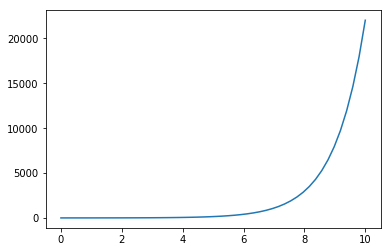

In [5]:

#ax = plt.subplot(111)
x = np.linspace(0, 10)
y = np.exp(x)
plt.plot(x,y)

In [10]:
%matplotlib notebook


with open("./notMNIST_large/I.pickle",'rb') as fid:
    ax = pickle.load(fid)
    x= np.linspace(0,len(ax))
    y= ax 
   # print(ax[0])
    #print("-------------------------------------")
    print(ax)
    train_datasets[0][0][0]

#plt.plot(x,y)
#plt.show("./notMNIST/I.pickle")

[[[ 0.17450981  0.5         0.5        ...  0.5         0.5
    0.22941177]
  [ 0.09607843  0.4019608   0.39411765 ...  0.39411765  0.4019608
    0.11960784]
  [-0.5        -0.4882353  -0.4882353  ... -0.4882353  -0.4882353
   -0.5       ]
  ...
  [-0.5        -0.49215686 -0.4882353  ... -0.4882353  -0.4882353
   -0.5       ]
  [-0.15490197  0.38627452  0.39803922 ...  0.39411765  0.4019608
    0.13137256]
  [-0.0882353   0.5         0.5        ...  0.5         0.5
    0.21764706]]

 [[-0.5        -0.5        -0.5        ...  0.41764706  0.24117647
   -0.39411765]
  [-0.5        -0.5        -0.5        ...  0.5         0.34313726
   -0.30392158]
  [-0.5        -0.5        -0.5        ...  0.47254902  0.24901961
   -0.48039216]
  ...
  [-0.5        -0.36666667  0.20196079 ... -0.5        -0.5
   -0.5       ]
  [-0.4372549   0.24117647  0.46862745 ... -0.5        -0.5
   -0.5       ]
  [-0.01372549  0.10784314 -0.05686275 ... -0.5        -0.5
   -0.5       ]]

 [[ 0.5         0.5        

In [11]:
for a in ax:
    print(a[0][0])

0.17450981
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.17450981
-0.5
-0.5
-0.5
-0.5
-0.45686275
0.38235295
-0.5
-0.20588236
-0.5
0.5
-0.14705883
-0.49607843
0.24901961
0.5
-0.2372549
-0.5
0.4372549
0.5
-0.26078433
-0.5
-0.5
-0.5
-0.29215688
-0.5
-0.5
-0.15490197
-0.5
0.5
-0.5
-0.5
-0.20588236
-0.14313726
0.5
-0.49215686
-0.2647059
-0.5
-0.5
-0.21372549
-0.5
-0.1392157
0.5
0.5
-0.5
-0.5
-0.39411765
-0.44509804
-0.056862745
0.04117647
-0.5
-0.5
-0.5
-0.24509804
-0.5
-0.5
-0.5
-0.49607843
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.25686276
0.40588236
-0.1509804
-0.47254902
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
0.12745099
-0.5
-0.49607843
-0.5
-0.5
-0.5
0.5
0.30784315
0.5
0.44509804
-0.5
-0.15490197
-0.5
-0.5
-0.5
-0.24901961
-0.5
-0.36666667
0.5
-0.45686275
-0.5
-0.39411765
-0.5
0.14705883
-0.5
-0.5
0.5
-0.5
-0.5
-0.35882354
-0.20588236
-0.5
0.45686275
0.08039216
-0.49607843
-0.5
0.48431373
0.5
-0.5
-0.26078433
-0.5
-0.5
-0.49215686
-0.5
-0.5
0.38235295
0.5
-0.49607843
-0.24117647
-

0.5
-0.5
0.5
-0.5
-0.5
0.20980392
-0.5
-0.5
-0.34313726
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.49215686
-0.5
-0.49607843
-0.29607844
-0.5
-0.5
-0.5
-0.5
0.5
-0.46470588
-0.26078433
-0.5
-0.5
0.5
-0.5
0.5
-0.5
0.5
-0.5
-0.5
0.5
-0.5
-0.21372549
-0.5
-0.3745098
0.1392157
-0.22941177
-0.5
0.5
-0.5
-0.34705883
0.4882353
-0.5
-0.1392157
-0.5
0.4019608
0.5
-0.5
0.5
-0.27254903
-0.5
-0.5
-0.5
-0.5
0.44509804
0.5
-0.5
-0.5
0.10784314
-0.49607843
0.5
-0.17450981
-0.5
-0.3627451
0.3156863
-0.20980392
0.46078432
0.5
0.5
-0.5
0.5
0.46470588
-0.5
-0.20588236
-0.1392157
-0.5
0.22156863
-0.5
-0.5
-0.5
-0.24117647
-0.5
-0.5
0.5
-0.42941177
-0.41764706
0.37843138
-0.3
-0.5
-0.5
-0.5
-0.5
-0.5
-0.19803922
0.5
-0.5
-0.5
-0.5
0.45686275
0.5
-0.5
0.5
0.5
0.5
-0.5
-0.3509804
-0.37058824
-0.5
0.5
0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
0.29607844
-0.5
0.35882354
0.5
-0.5
-0.5
-0.060784314
-0.49607843
-0.5
-0.5
-0.40588236
-0.4882353
-0.5
-0.5
-0.5
-0.4764

0.5
-0.5
-0.04117647
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.12745099
-0.19411765
-0.5
-0.5
-0.5
-0.5
0.49215686
-0.5
-0.5
-0.4882353
-0.5
-0.5
-0.5
-0.5
-0.26862746
-0.49215686
-0.36666667
0.5
-0.5
-0.5
0.33529413
0.11176471
-0.5
-0.5
0.39019608
0.21372549
0.5
-0.49607843
0.37058824
0.5
-0.052941177
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.16666667
-0.5
-0.5
0.5
0.47254902
-0.49607843
-0.5
-0.49607843
-0.48039216
-0.5
-0.49215686
-0.5
-0.5
0.30784315
-0.5
0.5
-0.5
-0.5
-0.5
-0.2647059
-0.5
-0.5
-0.5
-0.11960784
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.4137255
-0.10392157
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
0.40588236
-0.5
-0.5
0.5
0.45294118
-0.5
-0.5
0.5
0.18235295
-0.5
0.5
-0.5
-0.5
0.5
0.5
0.5
-0.5
0.33137256
0.28039217
-0.5
0.48431373
-0.5
-0.5
-0.08039216
0.38627452
-0.5
-0.5
-0.17450981
0.0882353
-0.5
-0.5
-0.2372549
-0.5
0.28039217
0.2529412
-0.39803922
-0.48431373
-0.5
-0.5
-0.30392158
-0.5
0.32352942
-0.5
-0.17843138
-0.1
-0.10784314
0.327451
-0.5
-0.5
0.20980392
-0.49215686
-0.0450980

-0.23333333
-0.5
-0.34313726
-0.3745098
-0.5
-0.38627452
-0.3
-0.5
0.20588236
0.5
-0.5
0.5
0.45686275
-0.5
-0.04117647
-0.5
-0.18627451
0.04117647
-0.5
0.24901961
-0.07254902
-0.5
-0.5
-0.5
-0.5
0.48039216
0.068627454
-0.5
-0.21372549
-0.5
-0.49607843
0.3
0.5
-0.5
-0.26078433
-0.5
0.5
0.5
-0.17450981
-0.5
-0.5
-0.37843138
-0.5
0.068627454
-0.5
0.42156863
-0.5
-0.3392157
-0.5
-0.5
0.5
-0.5
0.5
0.01764706
-0.49607843
0.08431373
0.14313726
-0.24901961
0.5
-0.28431374
-0.39411765
0.5
-0.1509804
-0.5
-0.5
-0.5
0.5
-0.5
0.38627452
-0.5
-0.5
-0.5
-0.5
0.19411765
0.5
-0.033333335
-0.5
-0.17450981
-0.40980393
-0.5
-0.5
0.5
-0.115686275
-0.5
-0.5
-0.5
0.17450981
-0.5
-0.5
-0.5
0.5
-0.3
0.5
0.07647059
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.49607843
-0.5
-0.5
0.5
-0.5
-0.5
-0.4882353
-0.5
-0.5
-0.5
0.5
0.5
-0.5
-0.49607843
-0.48431373
-0.17058824
-0.5
-0.5
-0.5
0.18627451
0.4764706
-0.5
-0.5
-0.5
-0.5
-0.47254902
0.33529413
-0.46078432
-0.5
-0.15490197
-0.5
-0.5
-0.5
-0.5
0.46862745
-0.49607843

0.07647059
0.5
-0.5
-0.5
0.025490196
-0.49607843
0.5
-0.43333334
-0.5
0.5
-0.19411765
-0.27254903
0.5
-0.5
-0.17450981
-0.5
0.5
0.068627454
-0.5
0.5
-0.5
-0.42941177
-0.5
-0.5
-0.5
-0.49215686
0.17843138
-0.5
0.5
0.5
0.5
-0.5
-0.49215686
0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.064705886
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
0.068627454
-0.5
0.08039216
-0.45294118
0.5
-0.2647059
0.5
-0.4490196
-0.3392157
-0.029411765
-0.5
-0.5
-0.5
0.5
-0.48039216
0.5
0.3627451
-0.09607843
-0.5
-0.5
-0.5
0.27254903
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.49215686
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.45686275
0.4882353
0.5
-0.5
0.5
-0.5
-0.5
0.11960784
0.5
-0.5
0.45294118
-0.5
0.5
0.5
0.04117647
-0.5
-0.04901961
-0.5
-0.5
-0.5
-0.2647059
0.5
-0.10392157
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.49215686
0.49215686
-0.4764706
-0.5
-0.5
0.01764706
-0.14705883
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.2647059
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
0.5
0.20588236
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.34313726
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.45686275
0.

-0.49607843
-0.5
-0.5
0.28431374
-0.5
-0.5
0.5
0.17843138
-0.5
-0.5
-0.5
-0.5
0.30784315
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.327451
-0.5
-0.3509804
-0.5
-0.5
-0.5
-0.5
-0.092156865
-0.28431374
-0.15882353
-0.04901961
0.5
-0.5
0.49607843
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.33529413
-0.5
-0.5
-0.033333335
-0.5
-0.5
-0.037254903
-0.5
-0.11960784
-0.5
-0.4882353
0.5
0.5
0.064705886
-0.5
-0.49607843
-0.40588236
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.1627451
-0.5
-0.5
-0.49215686
-0.5
-0.4137255
-0.4490196
0.5
-0.5
0.037254903
-0.22941177
-0.1392157
0.08039216
-0.4882353
-0.35490197
0.5
-0.5
0.5
-0.28039217
-0.5
-0.3745098
-0.5
-0.49607843
-0.24901961
-0.4019608
-0.2529412
0.5
0.5
-0.5
-0.5
0.09607843
0.31176472
-0.48039216
-0.37058824
-0.5
-0.5
-0.01764706
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.2254902
0.5
-0.5
-0.41764706
0.38235295
-0.5
-0.5
-0.052941177
-0.5
-0.5
-0.5
-0.5
0.16666667
-0.5
0.32352942
-0.49215686
0.060784314
-0.18235295
-0.5
-0.5
0.5
0.5
-0.49215686
-0.2882353
-0.26862746
-0.33137256
-0.5
-0.

0.5
0.5
0.5
0.04117647
0.5
-0.5
-0.5
0.5
-0.5
-0.5
0.115686275
-0.5
-0.5
-0.29607844
-0.5
-0.24117647
-0.5
-0.20588236
-0.5
-0.49607843
-0.5
-0.5
-0.5
0.48039216
-0.5
-0.46862745
-0.5
-0.5
-0.5
-0.5
0.23333333
0.49607843
0.5
0.48039216
-0.5
-0.5
0.08039216
0.35882354
-0.5
-0.064705886
-0.5
-0.26078433
-0.5
-0.49215686
-0.5
-0.5
-0.5
-0.5
-0.3745098
-0.5
0.09607843
0.17843138
-0.5
-0.5
0.2372549
-0.5
-0.5
0.005882353
-0.5
-0.5
-0.34705883
0.5
-0.5
-0.5
0.5
0.5
0.5
-0.5
-0.5
0.5
0.4490196
0.14705883
0.1
-0.11176471
-0.5
-0.5
-0.005882353
0.5
-0.037254903
-0.3627451
-0.49215686
-0.5
-0.18235295
-0.46862745
-0.5
-0.5
-0.5
-0.12745099
-0.5
0.5
-0.49607843
-0.18235295
0.32352942
-0.5
-0.5
-0.40588236
-0.31960785
-0.5
0.5
-0.5
-0.49607843
-0.5
-0.5
-0.5
-0.5
0.5
0.31176472
0.5
0.07647059
-0.5
-0.24509804
0.5
-0.5
0.41764706
-0.5
0.5
-0.5
0.5
-0.25686276
0.37843138
-0.49607843
0.5
-0.037254903
-0.5
-0.5
0.39411765
-0.5
-0.5
0.22941177
-0.5
-0.38627452
-0.1627451
-0.5
-0.26078433
-0.5
-0.5
-0.5

-0.5
-0.5
-0.5
-0.5
0.15490197
0.46078432
-0.5
0.115686275
0.19411765
-0.5
0.5
-0.49607843
0.5
-0.005882353
-0.1392157
0.5
-0.5
0.5
-0.5
0.5
0.19019608
-0.5
-0.092156865
-0.5
-0.5
-0.5
0.5
-0.5
0.5
-0.5
-0.5
0.32352942
-0.5
-0.21764706
-0.49215686
-0.5
-0.40980393
0.5
-0.5
0.5
-0.49607843
-0.5
-0.23333333
-0.5
-0.5
-0.5
-0.5
0.1627451
0.38235295
-0.5
-0.052941177
-0.5
-0.5
-0.5
-0.5
-0.5
-0.1
-0.3627451
-0.5
-0.33529413
-0.5
-0.5
-0.5
-0.327451
0.5
0.44117647
-0.2372549
-0.5
0.5
0.5
-0.5
0.5
-0.5
-0.5
0.01372549
0.15490197
0.5
-0.5
-0.10392157
-0.5
-0.5
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.39411765
-0.5
0.45686275
-0.24509804
-0.115686275
0.5
-0.24509804
-0.5
-0.5
-0.5
-0.037254903
0.5
0.5
-0.42941177
-0.5
-0.5
-0.5
-0.5
-0.41764706
0.08431373
-0.49215686
0.28039217
0.5
-0.5
0.025490196
0.19803922
0.5
0.5
0.2764706
0.5
-0.5
-0.5
-0.49215686
-0.5
0.20196079
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.49215686
-0.48039216
0.11960784
0.2647059
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.4803

-0.5
-0.5
0.5
-0.5
0.5
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.12352941
-0.1
-0.5
-0.5
0.16666667
-0.5
-0.39803922
-0.5
0.34705883
-0.5
0.3156863
0.14313726
0.052941177
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.0882353
0.24901961
-0.30392158
-0.32352942
-0.5
-0.43333334
-0.33529413
-0.021568628
-0.5
-0.2764706
-0.5
0.5
-0.5
-0.029411765
0.04117647
0.052941177
-0.5
-0.49607843
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.29607844
-0.5
-0.5
-0.5
-0.09607843
0.5
-0.5
0.052941177
0.10392157
0.18627451
-0.5
-0.42156863
-0.5
-0.5
0.5
0.34313726
-0.4137255
0.04509804
0.5
0.5
-0.5
-0.5
0.4019608
-0.5
0.5
-0.5
-0.13137256
-0.4882353
-0.4882353
0.15490197
-0.0019607844
-0.5
-0.5
-0.5
-0.5
-0.5
0.46470588
-0.5
-0.3627451
0.2764706
0.5
0.2372549
0.5
-0.3392157
0.5
-0.5
0.5
-0.5
0.5
-0.38627452
-0.5
-0.5
-0.5
-0.060784314
-0.5
0.32352942
-0.08431373
-0.5
-0.037254903
-0.5
0.49215686
-0.5
-0.5
-0.49607843
-0.26078433
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.49215686
-0.5
0.45686275
-0.4372549
-0.04117

0.5
-0.5
-0.5
-0.5
-0.5
-0.14313726
-0.5
0.5
0.5
0.2372549
0.5
-0.5
-0.40588236
-0.5
-0.5
-0.49215686
-0.5
-0.5
-0.5
-0.5
0.5
0.13137256
-0.5
-0.49215686
-0.5
0.5
-0.5
-0.5
-0.20196079
-0.5
0.5
-0.5
-0.5
-0.5
0.5
-0.009803922
-0.5
-0.3392157
0.115686275
-0.5
-0.5
-0.5
0.5
-0.18235295
-0.5
-0.4882353
0.5
-0.4490196
0.4137255
-0.48431373
-0.07647059
-0.5
-0.5
-0.5
0.13137256
-0.46862745
-0.15882353
-0.2647059
0.5
-0.5
0.12745099
-0.5
-0.5
-0.5
-0.5
-0.5
0.13137256
-0.5
-0.5
0.037254903
0.42156863
-0.5
-0.5
-0.48039216
-0.42156863
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
0.49215686
-0.49607843
-0.5
0.4019608
-0.16666667
-0.34313726
-0.5
-0.39803922
-0.0019607844
0.45294118
0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.12745099
-0.5
-0.39411765
-0.5
-0.46078432
-0.5
-0.08039216
0.029411765
-0.5
-0.5
0.029411765
-0.48039216
-0.5
-0.20980392
0.5
-0.49607843
-0.49607843
0.17843138
-0.4372549
0.5
-0.5
-0.35882354
0.5
-0.21764706
-0.12745099
0.34705883
-0.5
0.12745099
0.17843138
0.5
-0.5
-0.5
-0.5
0.5
-0.5

-0.5
-0.21372549
-0.5
-0.46078432
0.5
0.45686275
-0.5
-0.49607843
-0.3745098
-0.1627451
-0.5
-0.48431373
0.18235295
-0.5
-0.5
-0.37058824
-0.5
0.38235295
0.5
-0.5
-0.5
-0.5
-0.26862746
-0.1392157
-0.5
0.48431373
-0.5
0.49607843
0.38235295
-0.19411765
-0.37843138
-0.4882353
-0.5
-0.18627451
0.37058824
-0.5
-0.5
-0.5
0.5
0.5
0.20196079
0.5
-0.29215688
-0.5
-0.068627454
-0.5
0.5
0.11176471
-0.5
-0.5
-0.5
-0.068627454
0.5
-0.5
-0.39019608
-0.5
-0.5
-0.5
-0.1392157
0.009803922
-0.5
-0.31960785
0.12745099
-0.19019608
-0.14705883
0.5
-0.5
-0.2647059
-0.5
0.16666667
-0.5
-0.5
-0.5
-0.1
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.18235295
-0.5
0.5
-0.5
-0.5
-0.35882354
0.13529412
-0.5
-0.5
-0.5
0.5
0.30392158
-0.5
-0.5
-0.5
-0.42941177
-0.3392157
-0.5
-0.5
0.33137256
-0.49215686
-0.46470588
-0.49607843
-0.2882353
-0.5
0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.1
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.15490197
-0.5
0.5
-0.5
-0.5
0.5
0.29215688
0.33137256
-0.5
-0.5
-0.5
0.5
-0.5
-0.44117647
0.5
0.5
-0.0529411

-0.5
0.5
0.5
-0.5
-0.5
0.5
0.14705883
-0.5
-0.009803922
-0.5
0.5
-0.5
0.5
-0.17450981
-0.12352941
0.16666667
0.07647059
-0.12745099
-0.5
-0.5
0.5
0.5
0.5
0.5
-0.5
-0.5
-0.35490197
-0.49607843
-0.5
-0.2764706
0.26862746
0.5
-0.025490196
-0.5
-0.2372549
-0.052941177
-0.033333335
0.1392157
0.5
0.5
0.5
0.47254902
-0.5
-0.5
-0.5
-0.5
-0.092156865
-0.40588236
-0.12745099
-0.5
0.2254902
-0.42156863
-0.5
-0.5
-0.5
0.37058824
-0.49607843
-0.5
-0.5
0.5
0.5
-0.07647059
-0.5
0.16666667
0.04117647
0.5
-0.33529413
0.0019607844
-0.5
0.38235295
0.5
0.5
-0.5
-0.5
0.056862745
-0.5
-0.5
0.2254902
-0.10392157
-0.5
-0.5
0.5
-0.5
-0.5
-0.04509804
-0.5
-0.5
0.40588236
-0.5
-0.5
-0.26078433
-0.5
-0.5
-0.20980392
-0.5
-0.11176471
-0.49215686
0.5
-0.5
-0.4490196
-0.04509804
-0.5
-0.42941177
-0.23333333
0.5
-0.5
-0.4019608
-0.38627452
-0.5
0.5
-0.40588236
0.12352941
-0.38627452
-0.18627451
-0.5
-0.056862745
-0.5
0.029411765
0.5
0.47254902
-0.5
-0.5
-0.26078433
0.33137256
0.43333334
-0.5
0.5
-0.42941177
-0.5
0.06

-0.4137255
-0.5
-0.5
-0.5
-0.5
-0.10392157
0.31176472
-0.5
-0.5
-0.5
-0.49215686
-0.5
-0.5
0.43333334
0.04117647
-0.5
0.5
0.20980392
-0.5
-0.5
-0.5
0.5
-0.24901961
-0.5
-0.5
-0.5
-0.5
0.27254903
0.5
-0.5
-0.5
-0.5
-0.5
0.20196079
-0.5
-0.5
0.5
-0.5
0.17058824
0.20588236
-0.4372549
-0.5
-0.10392157
-0.5
-0.5
0.5
-0.0882353
-0.5
0.27254903
0.5
0.23333333
-0.5
-0.5
0.32352942
-0.5
-0.39411765
-0.43333334
-0.5
-0.3509804
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.27254903
-0.5
0.5
-0.5
-0.5
0.20588236
-0.46862745
0.025490196
0.5
-0.5
0.14705883
-0.5
-0.49215686
0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.3627451
0.068627454
-0.5
0.12745099
-0.5
-0.5
-0.5
-0.49215686
-0.5
-0.46078432
0.5
-0.49215686
0.14705883
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
0.5
0.5
0.5
-0.08039216
-0.4882353
-0.5
0.31960785
-0.35490197
-0.3509804
0.19803922
-0.5
-0.5
-0.48039216
0.46862745
0.033333335
-0.5
-0.34705883
-0.5
0.5
-0.5
-0.12352941
-0.5
-0.5
-0.21764706
-0.5
-0.5
-0.327451
-0.5
-0.5
-0.3392157
-0.5
0.005882353
0.48431

0.060784314
-0.5
-0.5
-0.04901961
-0.19803922
-0.5
-0.5
-0.39803922
-0.5
-0.49607843
-0.20588236
-0.5
-0.5
-0.43333334
-0.5
-0.5
-0.5
-0.22156863
-0.5
-0.5
0.060784314
-0.49215686
0.17058824
-0.5
0.5
-0.5
-0.27254903
-0.5
-0.5
-0.49607843
0.36666667
-0.33529413
-0.060784314
0.5
-0.5
0.31176472
-0.5
-0.5
-0.5
-0.5
0.31960785
-0.5
0.5
0.0882353
-0.5
0.14313726
-0.115686275
0.5
-0.327451
0.5
-0.5
-0.17450981
0.5
0.5
0.5
-0.5
-0.5
0.46078432
-0.5
-0.5
-0.5
0.5
-0.18235295
-0.5
-0.5
-0.1392157
0.5
-0.26862746
-0.5
-0.5
0.19019608
-0.5
0.38235295
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.5
-0.5
-0.5
-0.21372549
-0.5
-0.5
0.5
-0.4490196
-0.18627451
-0.5
0.47254902
0.5
-0.28431374
-0.5
-0.49215686
0.5
-0.5
-0.5
-0.49215686
0.5
-0.30784315
0.5
-0.5
0.5
-0.5
0.5
-0.18627451
-0.5
-0.029411765
-0.5
-0.5
0.16666667
-0.5
0.5
0.5
-0.4137255
0.01764706
-0.056862745
-0.5
0.5
-0.34313726
0.48431373
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.1627451
-0.5
-0.5
-0.5
-0.5
-0.5
-0.488

0.5
-0.5
0.5
0.5
0.5
-0.5
0.48431373
0.037254903
0.0019607844
0.5
-0.5
-0.1509804
0.5
-0.19411765
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.08039216
0.5
0.34705883
-0.5
-0.17058824
-0.5
-0.04117647
-0.5
-0.5
-0.5
-0.5
-0.25686276
-0.5
0.025490196
-0.5
-0.5
-0.48039216
-0.5
-0.5
-0.5
-0.5
-0.48431373
-0.41764706
0.37843138
-0.07647059
-0.5
0.37843138
0.5
-0.5
-0.5
-0.48431373
-0.5
0.5
-0.5
0.44117647
-0.49215686
-0.44509804
0.5
-0.5
-0.5
-0.3156863
-0.5
-0.49607843
-0.5
0.064705886
-0.5
-0.5
-0.5
-0.5
0.49607843
-0.04117647
-0.5
0.46470588
-0.5
-0.5
-0.5
-0.5
0.5
0.5
-0.5
0.15490197
-0.5
-0.5
-0.5
-0.48431373
0.5
0.16666667
0.1392157
-0.064705886
0.5
0.42941177
0.5
0.44509804
-0.5
0.3509804
-0.5
-0.5
-0.5
-0.4019608
-0.11176471
-0.5
-0.5
-0.5
0.5
-0.5
0.46078432
-0.5
0.5
0.04117647
-0.5
-0.36666667
-0.5
0.18235295
-0.5
0.42156863
-0.5
0.5
-0.5
-0.1392157
-0.056862745
-0.44509804
0.5
0.5
0.5
-0.5
-0.5
-0.10392157
-0.5
-0.5
-0.5
0.5
0.5
0.35490197
-0.5
-0.5
0.5
0.115686275
-0.5
-

-0.5
0.20980392
-0.2372549
-0.5
-0.5
-0.41764706
0.49215686
0.060784314
-0.5
-0.5
-0.5
-0.5
-0.3745098
-0.5
0.5
-0.5
-0.5
-0.5
0.4137255
-0.49215686
-0.5
-0.5
0.5
-0.5
0.16666667
-0.5
-0.5
-0.5
-0.5
0.10784314
-0.5
-0.5
0.115686275
-0.5
-0.5
-0.2372549
-0.2529412
0.5
-0.37058824
0.5
0.4254902
-0.3
-0.5
-0.5
-0.3745098
0.5
0.5
-0.5
-0.44117647
-0.14705883
0.5
-0.5
0.30392158
-0.5
-0.5
-0.49215686
-0.5
-0.5
0.5
-0.5
-0.5
0.327451
0.5
0.5
0.33137256
-0.5
-0.5
-0.5
-0.5
0.5
0.11176471
-0.5
0.029411765
-0.5
-0.2372549
0.5
-0.04509804
-0.5
0.14313726
-0.5
0.16666667
-0.5
0.5
-0.5
-0.4490196
-0.5
-0.5
-0.40980393
-0.5
-0.5
0.5
-0.5
0.46862745
0.47254902
0.5
-0.5
-0.1392157
-0.5
0.26078433
-0.21372549
0.064705886
-0.4882353
-0.5
-0.24509804
-0.5
-0.46470588
-0.42941177
-0.5
-0.01764706
-0.5
0.037254903
-0.5
-0.5
0.0882353
0.5
-0.5
0.064705886
-0.5
0.27254903
0.22156863
-0.46470588
0.5
-0.5
0.33529413
0.20588236
-0.5
-0.5
-0.5
0.07647059
-0.5
-0.5
-0.5
0.5
0.13137256
-0.4490196
-0.5
-0.46470588

0.37843138
0.5
-0.5
0.19019608
0.5
-0.17058824
-0.5
-0.5
-0.5
0.42941177
0.13529412
-0.5
-0.46470588
0.5
-0.5
-0.5
-0.5
-0.49215686
-0.5
0.31176472
0.5
-0.5
-0.5
-0.29215688
0.5
-0.5
-0.5
0.5
-0.5
0.5
-0.5
0.5
0.44117647
0.5
-0.5
-0.5
-0.49607843
0.4019608
0.5
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.49607843
-0.49215686
-0.5
-0.5
-0.5
0.40980393
-0.5
-0.5
-0.49607843
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.49215686
-0.5
-0.5
0.5
-0.5
-0.5
0.3156863
-0.5
-0.5
-0.49215686
0.4372549
-0.5
-0.11176471
-0.5
-0.5
-0.22941177
-0.5
-0.46470588
0.46862745
-0.5
-0.5
-0.16666667
-0.48431373
-0.04901961
-0.5
0.46470588
-0.5
-0.5
-0.5
0.5
0.25686276
-0.5
-0.40588236
0.5
0.5
-0.46078432
-0.5
-0.5
-0.029411765
-0.4254902
0.5
-0.12745099
-0.5
0.14705883
0.5
0.5
-0.5
-0.5
0.4372549
-0.4764706
0.5
-0.5
0.5
-0.037254903
-0.18627451
-0.5
-0.5
-0.056862745
-0.5
0.18235295
-0.33137256
-0.1392157
0.5
0.5
-0.5
-0.5
-0.10392157
-0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.3745098
-0.5
0.5
-0.5
-0.37058824
-

-0.5
-0.5
-0.5
0.5
-0.5
0.24901961
-0.2372549
-0.07254902
0.4764706
-0.31960785
-0.5
0.5
-0.19803922
0.5
-0.5
-0.5
0.24509804
-0.037254903
-0.5
-0.5
-0.49215686
0.48431373
-0.5
-0.33529413
-0.5
0.09607843
-0.5
-0.5
-0.5
-0.5
-0.0019607844
-0.5
-0.5
-0.5
-0.49607843
-0.5
0.5
-0.5
-0.14313726
0.5
0.5
0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.2529412
-0.46862745
-0.5
-0.5
-0.5
0.5
-0.19803922
-0.4490196
0.0882353
-0.5
-0.327451
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.49607843
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.04509804
0.5
-0.5
0.5
-0.5
-0.1
-0.005882353
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
0.14313726
-0.36666667
0.5
-0.5
-0.5
0.5
-0.5
-0.46862745
0.37843138
-0.5
-0.5
0.35882354
-0.5
0.48431373
0.2882353
0.04901961
-0.5
-0.5
-0.10392157
-0.5
0.40588236
-0.5
0.5
-0.5
-0.5
0.22941177
0.39803922
0.5
-0.49607843
-0.04901961
-0.060784314
-0.4254902
-0.5
-0.11176471
-0.5
-0.1392157
-0.5
-0.24901961
-0.5
0.5
-0.5
-0.5
0.5
-0.35490197
-0.5
-0.5
0.5
0.5
-0.5
-0.5
-0.3
-0.5

-0.5
-0.5
-0.5
0.48039216
-0.20196079
-0.5
-0.5
-0.5
-0.5
0.5
-0.14705883
-0.13529412
-0.5
0.5
-0.49607843
0.21372549
-0.5
-0.5
-0.5
0.39019608
-0.1627451
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
0.5
-0.5
0.056862745
-0.30392158
0.5
-0.5
0.38627452
-0.5
-0.5
-0.5
0.16666667
-0.5
-0.5
-0.5
-0.48431373
-0.34313726
-0.5
0.5
-0.28039217
0.4764706
-0.4254902
-0.20588236
-0.5
-0.5
0.15490197
-0.5
0.2372549
0.5
-0.068627454
-0.5
-0.5
0.35882354
-0.5
-0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.29215688
-0.5
0.28431374
-0.28039217
-0.47254902
-0.12745099
-0.5
-0.32352942
-0.5
0.5
-0.5
-0.5
-0.5
-0.26862746
-0.5
-0.48039216
0.1
0.21372549
-0.5
0.5
-0.4254902
-0.5
-0.5
-0.5
-0.24117647
0.16666667
-0.49607843
-0.5
0.5
-0.5
-0.5
-0.5
-0.29607844
-0.12745099
0.5
0.22941177
-0.5
-0.5
-0.3
-0.42941177
-0.5
-0.5
0.5
0.5
-0.5
0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.5
-0.44509804
-0.04901961
-0.07254902
0.04901961
-0.29607844
-0.5
-0.13529412
-0.5
-0.5
0.15490197
-0.22941177
-0.5
-0.5
-0.5
-0.5
-0.5
-0.45686275
-0.